In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa
from itertools import combinations


json_folder = "annotations-files-label-studio"

project_names = [
    "Graphical Representations",
    "Clothing",
    "Crowd",
    "Interaction",
    "Environment",
]

annotator_ids = [64824, 64125]

print("Grundbibliotheken erfolgreich importiert.")


Grundbibliotheken erfolgreich importiert.


In [2]:
def analyze_json_structure(file_path):
    """Analysiert die Struktur einer Label Studio JSON-Datei"""
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, list):
        data = [data]

    print(f"Datei: {file_path}")
    print(f"Anzahl der Tasks: {len(data)}")

    if len(data) > 0:
        # Task-ID und Bildname des ersten Tasks
        example_task = data[0]
        print(f"Beispiel Task-ID: {example_task.get('id')}")

        image_path = None
        if "data" in example_task and "image" in example_task["data"]:
            image_path = example_task["data"]["image"]
        print(f"Beispiel Bildpfad: {image_path}")

        # Prüfen, ob die gesuchten Annotatoren vorhanden sind
        found_annotators = set()
        for task in data:
            for annotation in task.get("annotations", []):
                completed_by = annotation.get("completed_by", {})
                if isinstance(completed_by, dict):
                    annotator_id = completed_by.get("id")
                else:
                    annotator_id = completed_by
                if annotator_id:
                    found_annotators.add(annotator_id)

        print(f"Gefundene Annotatoren: {found_annotators}")
        print(
            f"Gesuchte Annotatoren vorhanden: {set(annotator_ids).issubset(found_annotators)}"
        )

        # Labels analysieren
        all_labels = set()
        for task in data:
            for annotation in task.get("annotations", []):
                for result in annotation.get("result", []):
                    value = result.get("value", {})
                    choices = value.get("choices", [])
                    if choices:
                        all_labels.update(choices)

        print(f"Gefundene Labels: {all_labels}")

    return data


# Beispielanalyse der ersten Datei, wenn vorhanden
json_files = [f for f in os.listdir(json_folder) if f.endswith(".json")]
if json_files:
    first_file = os.path.join(json_folder, json_files[0])
    _ = analyze_json_structure(first_file)
else:
    print(f"Keine JSON-Dateien im Ordner {json_folder} gefunden.")


Datei: annotations-files-label-studio\clothing-annotationen.json
Anzahl der Tasks: 308
Beispiel Task-ID: 157156146
Beispiel Bildpfad: olafscholz_26-09-2021_00:00_video7.jpeg
Gefundene Annotatoren: {64824, 61484, 64125}
Gesuchte Annotatoren vorhanden: True
Gefundene Labels: {'noFeatures', 'formalAttire', 'informalAttire'}


In [3]:
def extract_annotations(data, target_annotator_ids):
    """Extrahiert relevante Annotationsdaten aus den JSON-Dateien"""
    extracted_data = []

    for task in data:
        task_id = task.get("id")

        image_path = None
        if "data" in task and "image" in task["data"]:
            image_path = task["data"]["image"]

        task_entries = {}

        for annotation in task.get("annotations", []):
            completed_by = annotation.get("completed_by", {})
            if isinstance(completed_by, dict):
                annotator_id = completed_by.get("id")
            else:
                annotator_id = completed_by

            if annotator_id in target_annotator_ids:
                lead_time = annotation.get("lead_time", 0)
                project_id = task.get("project")

                if (task_id, annotator_id) not in task_entries:
                    task_entries[(task_id, annotator_id)] = {
                        "task_id": task_id,
                        "image": image_path,
                        "annotator_id": annotator_id,
                        "project_id": project_id,
                        "lead_time": lead_time,
                        "labels": [],
                    }

                # Ergebnisse aus den Annotationen extrahieren
                for result in annotation.get("result", []):
                    project_name = result.get("from_name", "unknown")
                    choices = result.get("value", {}).get("choices", [])

                    # Falls keine Auswahl getroffen wurde, no_features verwenden
                    if not choices:
                        choices = ["no_features"]

                    # Alle gewählten Labels speichern
                    task_entries[(task_id, annotator_id)]["labels"].extend(choices)
                    task_entries[(task_id, annotator_id)]["project_name"] = project_name

        extracted_data.extend(task_entries.values())

    return extracted_data


# Lese alle JSON-Dateien und extrahiere die relevanten Daten
all_data = []
json_files = [f for f in os.listdir(json_folder) if f.endswith(".json")]

for json_file in json_files:
    file_path = os.path.join(json_folder, json_file)
    print(f"Verarbeite {json_file}...")
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        if not isinstance(data, list):
            data = [data]  # Falls die Datei einen einzelnen Task enthält
        annotations = extract_annotations(data, annotator_ids)
        all_data.extend(annotations)

print(f"Insgesamt {len(all_data)} Annotationseinträge extrahiert.")


Verarbeite clothing-annotationen.json...
Verarbeite crowd-annotationen.json...
Verarbeite environment-annotationen.json...
Verarbeite graphicalRep-annotationen.json...
Verarbeite interaction-annotationen.json...
Insgesamt 3080 Annotationseinträge extrahiert.


In [4]:
def create_one_hot_encoded_dataframe(extracted_data):
    """Erstellt ein One-Hot-Encoded DataFrame für Multi-Label-Annotationen"""

    base_df = pd.DataFrame(extracted_data)

    unique_labels = set()
    for entry in extracted_data:
        if "labels" in entry and entry["labels"]:
            unique_labels.update(entry["labels"])
    unique_labels = sorted(list(unique_labels))

    print(f"Gefundene einzigartige Labels: {len(unique_labels)}")

    unique_images = sorted(set(entry["image"] for entry in extracted_data))
    one_hot_df = pd.DataFrame({"image": unique_images})

    for label in unique_labels:
        for annotator_id in annotator_ids:
            column_name = f"{label}_{annotator_id}"
            one_hot_df[column_name] = 0  # Standardwert: nicht ausgewählt

    for entry in extracted_data:
        image = entry["image"]
        annotator_id = entry["annotator_id"]
        labels = entry.get("labels", [])

        # Setze den Wert auf 1 für jedes Label, das dieser Annotator für dieses Bild gewählt hat
        for label in labels:
            column_name = f"{label}_{annotator_id}"
            if column_name in one_hot_df.columns:
                one_hot_df.loc[one_hot_df["image"] == image, column_name] = 1

    return base_df, one_hot_df, unique_labels


# One-Hot-Encoding DataFrame erstellen
base_df, one_hot_df, unique_labels = create_one_hot_encoded_dataframe(all_data)

if one_hot_df is not None:
    print(
        f"One-Hot-Encoded DataFrame mit {one_hot_df.shape[0]} Zeilen und {one_hot_df.shape[1]} Spalten erstellt."
    )
    print("\nErste Zeilen des DataFrames:")
    display(base_df.head())

    print("\nErste Zeilen des One-Hot-Encoded DataFrames:")
    display(one_hot_df.head())


Gefundene einzigartige Labels: 15
One-Hot-Encoded DataFrame mit 308 Zeilen und 31 Spalten erstellt.

Erste Zeilen des DataFrames:


,task_id,image,annotator_id,project_id,lead_time,labels,project_name
0,157156146,olafscholz_26-09-2021_00:00_video7.jpeg,64824,129127,3.404,[informalAttire],Clothing
1,157156146,olafscholz_26-09-2021_00:00_video7.jpeg,64125,129127,1.913,[informalAttire],Clothing
2,157156147,christlichsozialeunion_18-09-2021_00:00_image1...,64125,129127,2.987,[formalAttire],Clothing
3,157156147,christlichsozialeunion_18-09-2021_00:00_image1...,64824,129127,5.713,"[formalAttire, informalAttire]",Clothing
4,157156148,abaerbock/2021-09-24_11-50-01_UTC_3.jpg,64824,129127,2.844,[informalAttire],Clothing



Erste Zeilen des One-Hot-Encoded DataFrames:


,image,admiringPeople_64824,admiringPeople_64125,affinityGestures_64824,affinityGestures_64125,approvingAudiences_64824,approvingAudiences_64125,campaignParaphernalia_64824,campaignParaphernalia_64125,children_64824,...,largeAudiences_64824,largeAudiences_64125,noFeatures_64824,noFeatures_64125,ordinaryPeople_64824,ordinaryPeople_64125,patrioticSymbols_64824,patrioticSymbols_64125,physicalEmbraces_64824,physicalEmbraces_64125
0,abaerbock/2021-09-13_14-02-02_UTC.jpg,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,abaerbock/2021-09-13_19-36-55_UTC_3.jpg,1,0,0,0,0,0,0,1,1,...,0,0,1,1,0,1,0,0,0,0
2,abaerbock/2021-09-14_10-00-20_UTC_5.jpg,0,0,0,0,0,0,1,0,0,...,1,0,1,1,0,0,0,0,0,0
3,abaerbock/2021-09-15_13-20-23_UTC_5.jpg,1,0,0,0,0,1,1,1,0,...,1,1,1,1,0,0,0,0,0,0
4,abaerbock/2021-09-17_19-48-04_UTC_1.jpg,1,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0


In [5]:
def calculate_statistics(base_df, one_hot_df, unique_labels):
    """Berechnet grundlegende Statistiken über die Annotationen"""
    if base_df is None or one_hot_df is None:
        print("Keine Daten für Statistiken vorhanden.")
        return None

    stats = {}

    # Anzahl der Labels pro Annotator
    label_counts = {}
    for annotator_id in annotator_ids:
        label_counts[annotator_id] = {}
        for label in unique_labels:
            column_name = f"{label}_{annotator_id}"
            if column_name in one_hot_df.columns:
                count = one_hot_df[column_name].sum()
                label_counts[annotator_id][label] = count

    stats["label_counts"] = pd.DataFrame(label_counts)

    # Durchschnittliche Zeit pro Bild pro Annotator
    avg_time_per_annotator = base_df.groupby("annotator_id")["lead_time"].mean()
    stats["avg_time_per_annotator"] = avg_time_per_annotator

    # Gesamtzeit pro Annotator
    total_time_per_annotator = base_df.groupby("annotator_id")["lead_time"].sum()
    stats["total_time_per_annotator"] = total_time_per_annotator

    # Durchschnittliche Anzahl von Labels pro Bild
    labels_per_image_annotator = {}
    for annotator_id in annotator_ids:
        label_columns = [
            col for col in one_hot_df.columns if col.endswith(f"_{annotator_id}")
        ]
        labels_per_image_annotator[annotator_id] = (
            one_hot_df[label_columns].sum(axis=1).mean()
        )

    stats["avg_labels_per_image"] = pd.Series(labels_per_image_annotator)

    return stats


# Statistiken berechnen
stats = calculate_statistics(base_df, one_hot_df, unique_labels)

if stats:
    print("Label-Häufigkeiten pro Annotator:")
    display(stats["label_counts"])

    print("\nDurchschnittliche Zeit (Sekunden) pro Bild pro Annotator:")
    display(stats["avg_time_per_annotator"])

    print("\nGesamtzeit (Sekunden) pro Annotator:")
    display(stats["total_time_per_annotator"])

    print("\nDurchschnittliche Anzahl von Labels pro Bild pro Annotator:")
    display(stats["avg_labels_per_image"])


Label-Häufigkeiten pro Annotator:


,64824,64125
admiringPeople,66,6
affinityGestures,3,11
approvingAudiences,0,5
campaignParaphernalia,161,193
children,9,16
formalAttire,162,161
identifiableEntourage,89,115
informalAttire,138,150
interactionWithCrowds,8,1
interactionWithSupporters,40,48



Durchschnittliche Zeit (Sekunden) pro Bild pro Annotator:


annotator_id
64125    7.684325
64824    4.524176
Name: lead_time, dtype: float64


Gesamtzeit (Sekunden) pro Annotator:


annotator_id
64125    11833.860
64824     6967.231
Name: lead_time, dtype: float64


Durchschnittliche Anzahl von Labels pro Bild pro Annotator:


64824    3.662338
64125    3.844156
dtype: float64

<Figure size 1400x800 with 0 Axes>

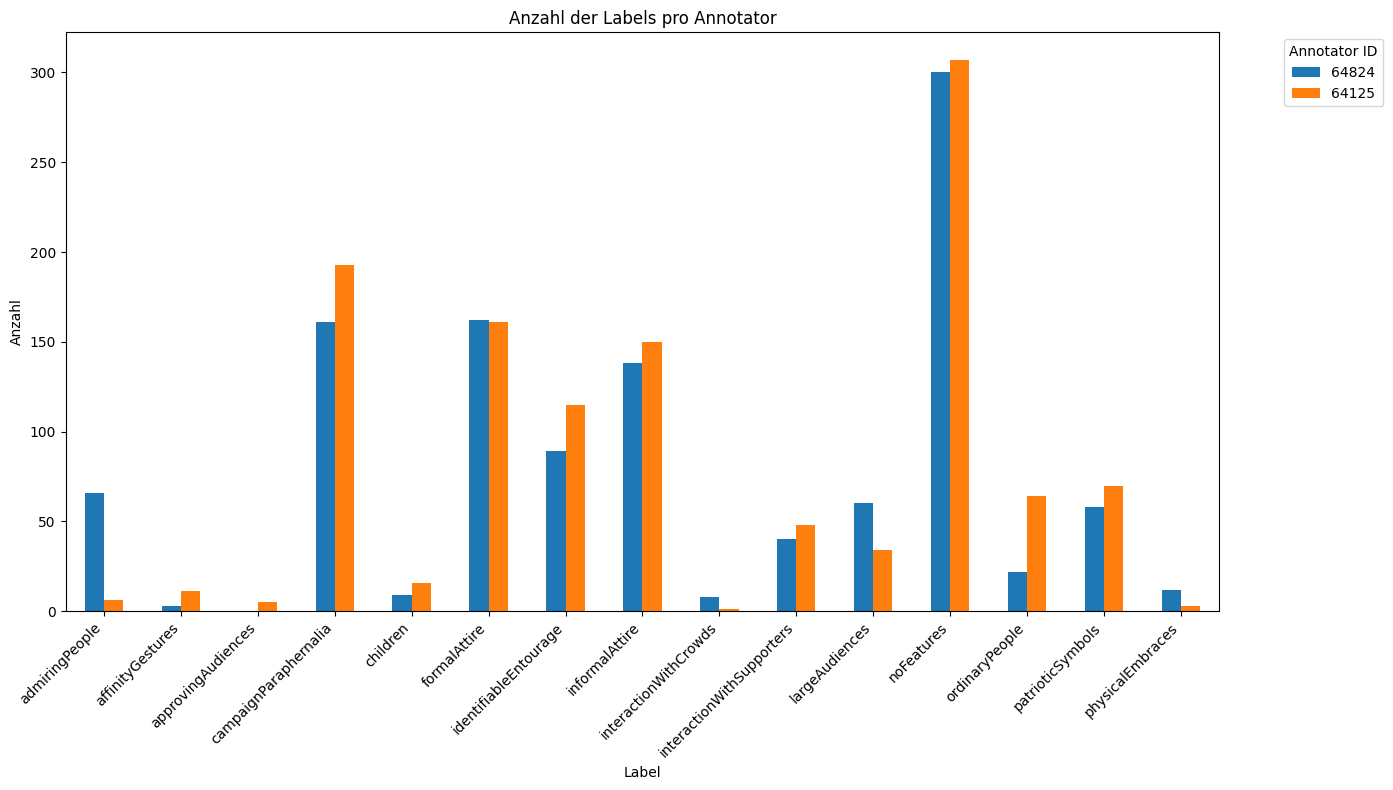

In [6]:
def plot_label_distribution(stats):
    """Visualisiert die Verteilung der Labels pro Annotator"""
    if stats is None or "label_counts" not in stats:
        print("Keine Daten für Visualisierung vorhanden.")
        return

    plt.figure(figsize=(14, 8))

    # Label-Häufigkeiten pro Annotator
    label_counts = stats["label_counts"]

    # Balkendiagramm erstellen
    ax = label_counts.plot(kind="bar", figsize=(14, 8))
    plt.title("Anzahl der Labels pro Annotator")
    plt.xlabel("Label")
    plt.ylabel("Anzahl")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Annotator ID", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

    # Speichern und Anzeigen
    plt.savefig("label_distribution.png")
    plt.show()


# Visualisierung der Label-Verteilung
plot_label_distribution(stats)


In [7]:
def calculate_agreement_metrics_one_hot(one_hot_df, unique_labels):
    """Berechnet Agreement-Metriken basierend auf One-Hot-Encoding"""
    if one_hot_df is None or one_hot_df.empty:
        print("Keine Daten für Metriken vorhanden.")
        return None

    metrics_results = {}

    for label in unique_labels:
        col1 = f"{label}_{annotator_ids[0]}"
        col2 = f"{label}_{annotator_ids[1]}"

        if col1 in one_hot_df.columns and col2 in one_hot_df.columns:
            rater1 = one_hot_df[col1].values
            rater2 = one_hot_df[col2].values

            try:
                # Cohen's Kappa
                cohen = cohen_kappa_score(rater1, rater2)

                # F1, Precision, Recall
                f1 = f1_score(rater1, rater2, zero_division=0)
                precision = precision_score(rater1, rater2, zero_division=0)
                recall = recall_score(rater1, rater2, zero_division=0)

                # Fleiss Kappa
                n_items = len(rater1)
                table = np.zeros((n_items, 2))
                for i in range(n_items):
                    if rater1[i] == 0 and rater2[i] == 0:
                        table[i, 0] = 2  # Beide wählten "0"
                    elif rater1[i] == 1 and rater2[i] == 1:
                        table[i, 1] = 2  # Beide wählten "1"
                    else:
                        table[i, 0] = 1  # Einer wählte "0"
                        table[i, 1] = 1  # Einer wählte "1"

                fleiss = fleiss_kappa(table)

                # Für Krippendorff's Alpha
                data_array = np.array([rater1, rater2])
                alpha = krippendorff.alpha(data_array, level_of_measurement="nominal")

                metrics_results[label] = {
                    "cohen_kappa": cohen,
                    "fleiss_kappa": fleiss,
                    "krippendorff_alpha": alpha,
                    "f1_score": f1,
                    "precision": precision,
                    "recall": recall,
                }
            except Exception as e:
                print(f"Fehler bei der Berechnung für Label {label}: {e}")
                metrics_results[label] = {
                    "cohen_kappa": np.nan,
                    "fleiss_kappa": np.nan,
                    "krippendorff_alpha": np.nan,
                    "f1_score": np.nan,
                    "precision": np.nan,
                    "recall": np.nan,
                }

    return metrics_results


label_metrics = calculate_agreement_metrics_one_hot(one_hot_df, unique_labels)

if label_metrics:
    metrics_df = pd.DataFrame.from_dict(label_metrics, orient="index")
    print("Inter-Rater-Agreement-Metriken für einzelne Labels:")
    display(metrics_df)

    metrics_df.to_csv("label_metrics.csv")
    print("Metriken als 'label_metrics.csv' gespeichert.")


Inter-Rater-Agreement-Metriken für einzelne Labels:


,cohen_kappa,fleiss_kappa,krippendorff_alpha,f1_score,precision,recall
admiringPeople,0.106996,0.024918,0.026501,0.138889,0.833333,0.075758
affinityGestures,0.274611,0.269103,0.270290,0.285714,0.181818,0.666667
approvingAudiences,0.000000,-0.008183,-0.006547,0.000000,0.000000,0.000000
campaignParaphernalia,0.671544,0.667917,0.668456,0.858757,0.787565,0.944099
children,0.709120,0.708156,0.708629,0.720000,0.562500,1.000000
formalAttire,0.785207,0.785205,0.785554,0.897833,0.900621,0.895062
identifiableEntourage,0.418347,0.413668,0.414620,0.607843,0.539130,0.696629
informalAttire,0.765601,0.765244,0.765625,0.875000,0.840000,0.913043
interactionWithCrowds,0.217707,0.210690,0.211971,0.222222,1.000000,0.125000
interactionWithSupporters,0.576341,0.575758,0.576446,0.636364,0.583333,0.700000


Metriken als 'label_metrics.csv' gespeichert.


In [8]:
def map_labels_to_categories():
    """Erstellt eine Zuordnung von Labels zu ihren übergeordneten Kategorien"""
    category_mapping = {
        # Statesmanship
        "campaignParaphernalia": "Statesmanship",
        "patrioticSymbols": "Statesmanship",
        "formalAttire": "Statesmanship",
        "identifiableEntourage": "Statesmanship",
        # Compassion
        "interactionWithSupporters": "Compassion",
        "physicalEmbraces": "Compassion",
        "affinityGestures": "Compassion",
        "children": "Compassion",
        "admiringPeople": "Compassion",
        # MassAppeal
        "largeAudiences": "MassAppeal",
        "approvingAudiences": "MassAppeal",
        "interactionWithCrowds": "MassAppeal",
        # Ordinariness
        "informalAttire": "Ordinariness",
        "ordinaryPeople": "Ordinariness",
        # Sonstiges
        "no_features": "NoFeatures",
    }

    return category_mapping


def create_category_dataframe(one_hot_df, unique_labels):
    """Erstellt ein DataFrame mit Kategorien statt einzelnen Labels"""
    if one_hot_df is None:
        print("Keine Daten für Kategorien vorhanden.")
        return None, None

    category_mapping = map_labels_to_categories()

    unique_categories = sorted(set(category_mapping.values()))

    category_df = one_hot_df[["image"]].copy()

    for category in unique_categories:
        for annotator_id in annotator_ids:
            column_name = f"{category}_{annotator_id}"
            category_df[column_name] = 0

    for label in unique_labels:
        if label in category_mapping:
            category = category_mapping[label]
            for annotator_id in annotator_ids:
                label_col = f"{label}_{annotator_id}"
                category_col = f"{category}_{annotator_id}"

                if (
                    label_col in one_hot_df.columns
                    and category_col in category_df.columns
                ):
                    # Wenn ein Label in einer Kategorie ausgewählt wurde, markiere die Kategorie als ausgewählt
                    category_df[category_col] = np.maximum(
                        category_df[category_col].values, one_hot_df[label_col].values
                    )

    return category_df, unique_categories


category_df, unique_categories = create_category_dataframe(one_hot_df, unique_labels)

if category_df is not None:
    print("Kategorie-DataFrame erstellt.")
    display(category_df.head())

    print("\nBerechne Metriken für Kategorien...")
    category_metrics = calculate_agreement_metrics_one_hot(
        category_df, unique_categories
    )

    if category_metrics:
        category_metrics_df = pd.DataFrame.from_dict(category_metrics, orient="index")
        print("Inter-Rater-Agreement-Metriken für Kategorien:")
        display(category_metrics_df)

        category_metrics_df.to_csv("category_metrics.csv")
        print("Kategorie-Metriken als 'category_metrics.csv' gespeichert.")


Kategorie-DataFrame erstellt.


,image,Compassion_64824,Compassion_64125,MassAppeal_64824,MassAppeal_64125,NoFeatures_64824,NoFeatures_64125,Ordinariness_64824,Ordinariness_64125,Statesmanship_64824,Statesmanship_64125
0,abaerbock/2021-09-13_14-02-02_UTC.jpg,0,0,0,0,0,0,1,0,0,1
1,abaerbock/2021-09-13_19-36-55_UTC_3.jpg,1,1,0,0,0,0,1,1,0,1
2,abaerbock/2021-09-14_10-00-20_UTC_5.jpg,0,0,1,0,0,0,0,1,1,0
3,abaerbock/2021-09-15_13-20-23_UTC_5.jpg,1,0,1,1,0,0,1,1,1,1
4,abaerbock/2021-09-17_19-48-04_UTC_1.jpg,1,0,1,1,0,0,1,1,0,0



Berechne Metriken für Kategorien...
Fehler bei der Berechnung für Label NoFeatures: There has to be more than one value in the domain.
Inter-Rater-Agreement-Metriken für Kategorien:


C:\Users\ckurr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\ckurr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\ckurr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\inter_rater.py:266: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)


,cohen_kappa,fleiss_kappa,krippendorff_alpha,f1_score,precision,recall
Compassion,0.599344,0.598230,0.598883,0.697368,0.768116,0.638554
MassAppeal,0.619783,0.614183,0.614810,0.673684,0.941176,0.524590
NoFeatures,NaN,NaN,NaN,NaN,NaN,NaN
Ordinariness,0.639042,0.635611,0.636202,0.826087,0.755682,0.910959
Statesmanship,0.521108,0.520826,0.521604,0.938547,0.929889,0.947368


Kategorie-Metriken als 'category_metrics.csv' gespeichert.


<Figure size 1400x800 with 0 Axes>

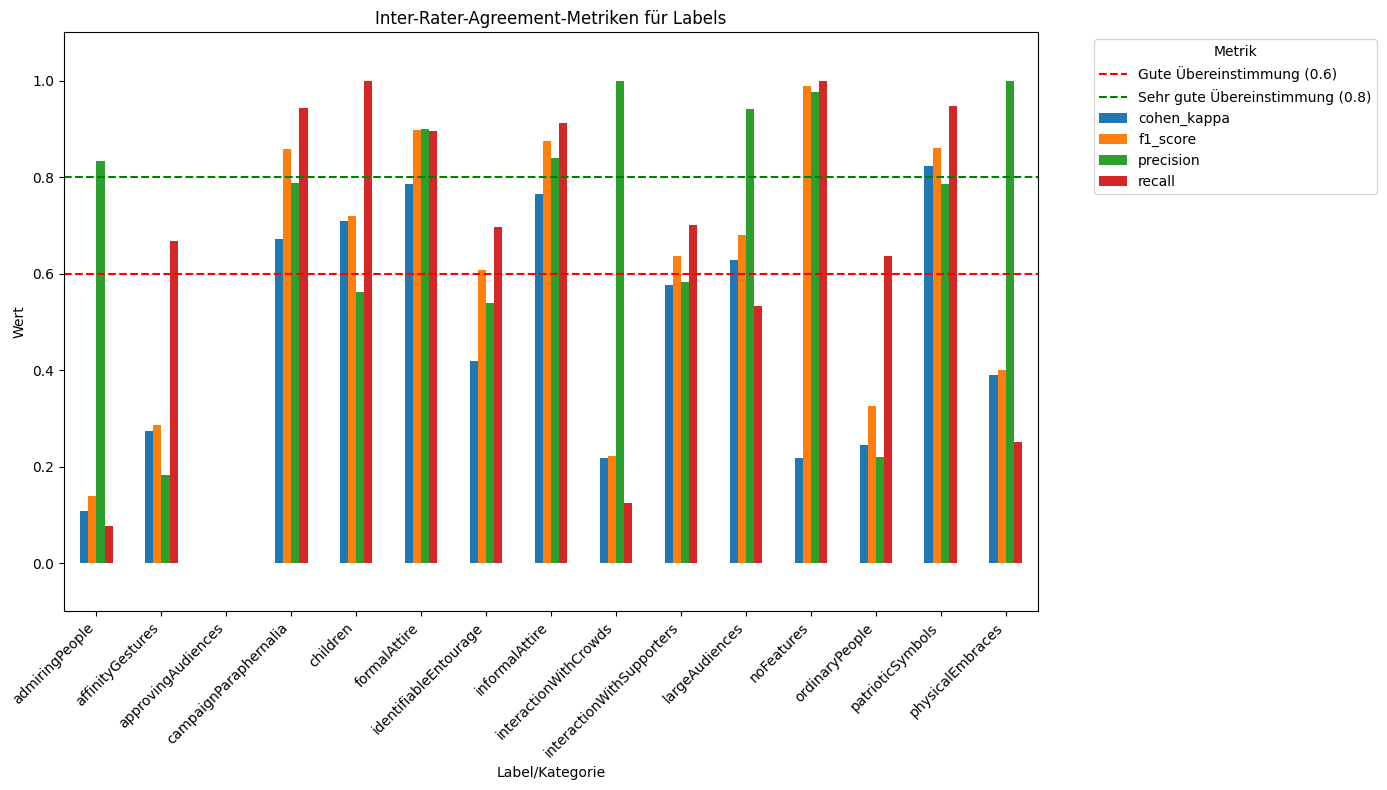

<Figure size 1400x800 with 0 Axes>

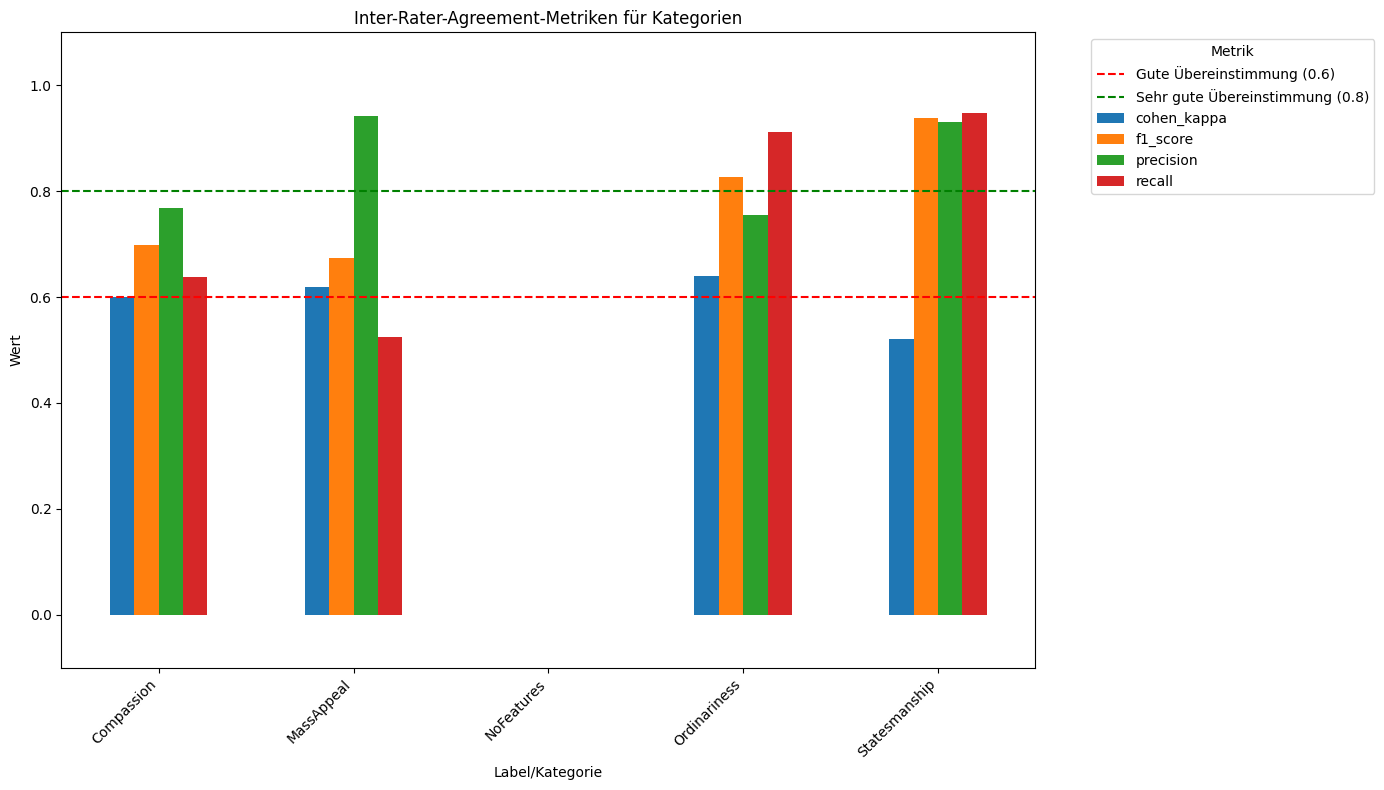

In [9]:
def plot_metrics(metrics_df, title, filename):
    """Visualisiert die Metriken als Balkendiagramm"""
    if metrics_df is None or metrics_df.empty:
        print("Keine Daten für Visualisierung vorhanden.")
        return

    plt.figure(figsize=(14, 8))

    selected_metrics = ["cohen_kappa", "f1_score", "precision", "recall"]
    metrics_to_plot = metrics_df[selected_metrics]

    ax = metrics_to_plot.plot(kind="bar", figsize=(14, 8))
    plt.title(title)
    plt.xlabel("Label/Kategorie")
    plt.ylabel("Wert")
    plt.axhline(y=0.6, color="r", linestyle="--", label="Gute Übereinstimmung (0.6)")
    plt.axhline(
        y=0.8, color="g", linestyle="--", label="Sehr gute Übereinstimmung (0.8)"
    )
    plt.legend(title="Metrik", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.ylim(-0.1, 1.1)  # Wertebereich für Metriken
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.savefig(filename)
    plt.show()


if "metrics_df" in locals() and not metrics_df.empty:
    plot_metrics(
        metrics_df,
        "Inter-Rater-Agreement-Metriken für Labels",
        "label_metrics_plot.png",
    )


if "category_metrics_df" in locals() and not category_metrics_df.empty:
    plot_metrics(
        category_metrics_df,
        "Inter-Rater-Agreement-Metriken für Kategorien",
        "category_metrics_plot.png",
    )


In [10]:
def save_results(base_df, one_hot_df, category_df):
    """Speichert alle Ergebnisse als CSV-Dateien"""
    if base_df is not None:
        base_df.to_csv("annotationen_detailliert.csv", index=False)
        print(
            "Detaillierte Annotationen als 'annotationen_detailliert.csv' gespeichert."
        )

    if one_hot_df is not None:
        one_hot_df.to_csv("one_hot_encoded_data.csv", index=False)
        print("One-Hot-Encoded Daten als 'one_hot_encoded_data.csv' gespeichert.")

    if category_df is not None:
        category_df.to_csv("kategorien_encoded.csv", index=False)
        print("Kategorie-Daten als 'kategorien_encoded.csv' gespeichert.")

    if "label_metrics" in locals() and "category_metrics" in locals():
        all_results = {
            "label_metrics": label_metrics,
            "category_metrics": category_metrics,
            "statistics": {
                "label_counts": stats["label_counts"].to_dict()
                if "stats" in locals()
                else {},
                "total_time": stats["total_time_per_annotator"].to_dict()
                if "stats" in locals()
                else {},
            },
        }

        with open("alle_ergebnisse.json", "w", encoding="utf-8") as f:
            json.dump(all_results, f, indent=4)
        print("Alle Ergebnisse als 'alle_ergebnisse.json' gespeichert.")


save_results(base_df, one_hot_df, category_df)
print("Alle Analysen abgeschlossen und Ergebnisse gespeichert.")


Detaillierte Annotationen als 'annotationen_detailliert.csv' gespeichert.
One-Hot-Encoded Daten als 'one_hot_encoded_data.csv' gespeichert.
Kategorie-Daten als 'kategorien_encoded.csv' gespeichert.
Alle Analysen abgeschlossen und Ergebnisse gespeichert.


Berechne Jaccard-Ähnlichkeitsindex...
Durchschnittlicher Jaccard-Index über alle Bilder: 0.7305

Jaccard-Index pro Label:


,Label,Jaccard-Index
11,noFeatures,0.977199
5,formalAttire,0.814607
7,informalAttire,0.777778
13,patrioticSymbols,0.753425
3,campaignParaphernalia,0.752475
4,children,0.562500
10,largeAudiences,0.516129
9,interactionWithSupporters,0.466667
6,identifiableEntourage,0.436620
14,physicalEmbraces,0.250000


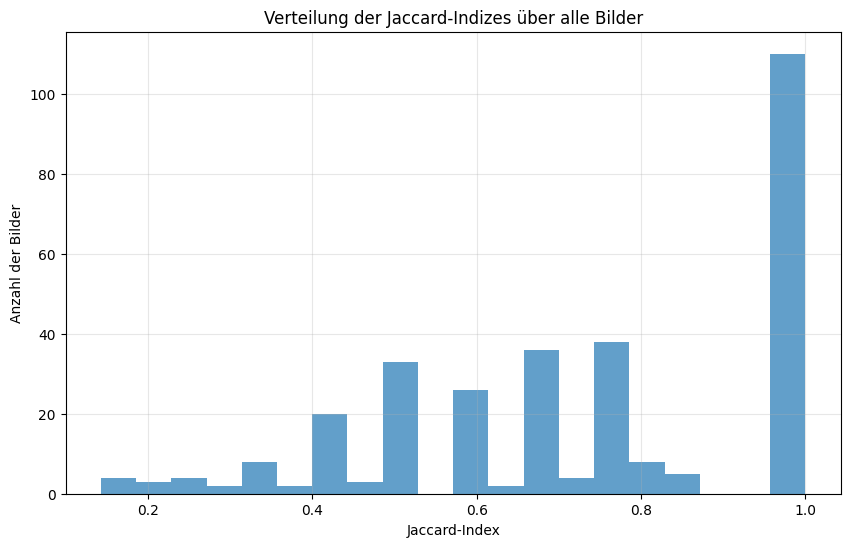

In [11]:
def calculate_jaccard_similarity(one_hot_df, unique_labels, annotator_ids):
    """Berechnet den Jaccard-Ähnlichkeitsindex für Multi-Label-Annotationen"""

    jaccard_per_image = []

    for _, row in one_hot_df.iterrows():
        labels_anno1 = set()
        labels_anno2 = set()

        for label in unique_labels:
            col1 = f"{label}_{annotator_ids[0]}"
            col2 = f"{label}_{annotator_ids[1]}"

            if col1 in row and row[col1] == 1:
                labels_anno1.add(label)
            if col2 in row and row[col2] == 1:
                labels_anno2.add(label)

        intersection = len(labels_anno1.intersection(labels_anno2))
        union = len(labels_anno1.union(labels_anno2))

        if union > 0:
            jaccard = intersection / union
        else:
            jaccard = 1.0

        jaccard_per_image.append(jaccard)

    avg_jaccard = (
        sum(jaccard_per_image) / len(jaccard_per_image) if jaccard_per_image else 0
    )

    jaccard_per_label = {}
    for label in unique_labels:
        col1 = f"{label}_{annotator_ids[0]}"
        col2 = f"{label}_{annotator_ids[1]}"

        if col1 in one_hot_df.columns and col2 in one_hot_df.columns:
            intersection = ((one_hot_df[col1] == 1) & (one_hot_df[col2] == 1)).sum()
            union = ((one_hot_df[col1] == 1) | (one_hot_df[col2] == 1)).sum()

            if union > 0:
                jaccard_per_label[label] = intersection / union
            else:
                jaccard_per_label[label] = 1.0

    return avg_jaccard, jaccard_per_image, jaccard_per_label


print("Berechne Jaccard-Ähnlichkeitsindex...")
avg_jaccard, jaccard_per_image, jaccard_per_label = calculate_jaccard_similarity(
    one_hot_df, unique_labels, annotator_ids
)

print(f"Durchschnittlicher Jaccard-Index über alle Bilder: {avg_jaccard:.4f}")
print("\nJaccard-Index pro Label:")
jaccard_label_df = pd.DataFrame(
    list(jaccard_per_label.items()), columns=["Label", "Jaccard-Index"]
)
jaccard_label_df = jaccard_label_df.sort_values(by="Jaccard-Index", ascending=False)
display(jaccard_label_df)

plt.figure(figsize=(10, 6))
plt.hist(jaccard_per_image, bins=20, alpha=0.7)
plt.title("Verteilung der Jaccard-Indizes über alle Bilder")
plt.xlabel("Jaccard-Index")
plt.ylabel("Anzahl der Bilder")
plt.grid(True, alpha=0.3)
plt.savefig("jaccard_distribution.png")
plt.show()


In [12]:
def calculate_credibility(one_hot_df, unique_labels, annotator_ids):
    """
    Berechnet die Credibility-Metrik für jede Annotation
    Credibility wird hier als die Wahrscheinlichkeit definiert, dass eine Annotation korrekt ist,
    basierend auf der Übereinstimmung zwischen den Annotatoren
    """

    credibility_df = one_hot_df[["image"]].copy()

    for label in unique_labels:
        col1 = f"{label}_{annotator_ids[0]}"
        col2 = f"{label}_{annotator_ids[1]}"

        if col1 in one_hot_df.columns and col2 in one_hot_df.columns:
            credibility_df[f"credibility_{label}"] = (
                one_hot_df[col1] == one_hot_df[col2]
            ).astype(float)

    credibility_df["avg_credibility"] = credibility_df[
        [col for col in credibility_df.columns if col.startswith("credibility_")]
    ].mean(axis=1)

    credibility_per_label = {}
    for label in unique_labels:
        col_name = f"credibility_{label}"
        if col_name in credibility_df.columns:
            credibility_per_label[label] = credibility_df[col_name].mean()

    overall_credibility = credibility_df["avg_credibility"].mean()

    return credibility_df, credibility_per_label, overall_credibility


print("Berechne Credibility-Metrik...")
credibility_df, credibility_per_label, overall_credibility = calculate_credibility(
    one_hot_df, unique_labels, annotator_ids
)

print(f"Gesamtdurchschnittliche Credibility: {overall_credibility:.4f}")
print("\nCredibility pro Label:")
credibility_label_df = pd.DataFrame(
    list(credibility_per_label.items()), columns=["Label", "Credibility"]
)
credibility_label_df = credibility_label_df.sort_values(
    by="Credibility", ascending=False
)
display(credibility_label_df)


low_credibility = credibility_df.sort_values(by="avg_credibility").head(10)
print("\nTop 10 Bilder mit der niedrigsten Credibility (potenziell problematisch):")
display(low_credibility[["image", "avg_credibility"]])


Berechne Credibility-Metrik...
Gesamtdurchschnittliche Credibility: 0.9039

Credibility pro Label:


,Label,Credibility
2,approvingAudiences,0.983766
4,children,0.977273
8,interactionWithCrowds,0.977273
11,noFeatures,0.977273
14,physicalEmbraces,0.970779
1,affinityGestures,0.967532
13,patrioticSymbols,0.941558
10,largeAudiences,0.902597
9,interactionWithSupporters,0.896104
5,formalAttire,0.892857



Top 10 Bilder mit der niedrigsten Credibility (potenziell problematisch):


,image,avg_credibility
74,armin_laschet_19-09-2021_00:00_image5.jpeg,0.466667
252,olafscholz/2021-09-20_18-06-50_UTC_1.jpg,0.600000
32,abaerbock_22-09-2021_00:00_image5.jpeg,0.600000
277,olafscholz_23-09-2021_00:00_image4.jpeg,0.600000
287,olafscholz_26-09-2021_00:00_image3.jpeg,0.600000
82,armin_laschet_23-09-2021_00:00_image3.jpeg,0.666667
64,armin_laschet_17-09-2021_00:00_image7.jpeg,0.666667
73,armin_laschet_19-09-2021_00:00_image4.jpeg,0.666667
136,cdu_17-09-2021_00:00_image2.jpeg,0.666667
147,cdu_22-09-2021_00:00_video3.jpeg,0.666667


Berechne Annotationseffizienz...

Annotationseffizienz für Annotator 64824:
Gesamtzeit: 6967.23 Sekunden
Durchschnittliche Zeit pro Bild: 4.52 Sekunden

Durchschnittliche Zeit pro Label:


,Label,Durchschnittliche Zeit (Sekunden),Anzahl
1,affinityGestures,14.553333,3
13,physicalEmbraces,9.809250,12
7,interactionWithCrowds,9.284500,8
11,ordinaryPeople,8.838909,22
8,interactionWithSupporters,7.064125,40
3,children,6.720111,9
2,campaignParaphernalia,6.706429,161
0,admiringPeople,5.925106,66
12,patrioticSymbols,4.962052,58
9,largeAudiences,4.634900,60


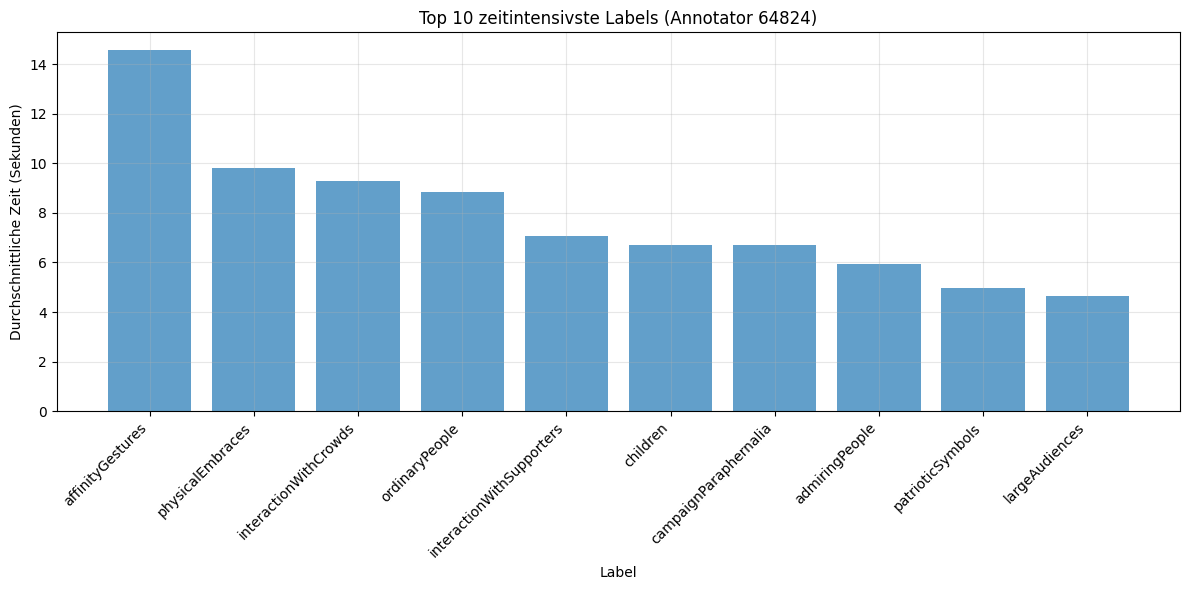


Annotationseffizienz für Annotator 64125:
Gesamtzeit: 11833.86 Sekunden
Durchschnittliche Zeit pro Bild: 7.68 Sekunden

Durchschnittliche Zeit pro Label:


,Label,Durchschnittliche Zeit (Sekunden),Anzahl
0,admiringPeople,37.082333,6
2,approvingAudiences,24.301200,5
10,largeAudiences,23.393382,34
12,ordinaryPeople,17.900781,64
4,children,16.970437,16
13,patrioticSymbols,15.183986,70
14,physicalEmbraces,14.853333,3
1,affinityGestures,14.548455,11
9,interactionWithSupporters,13.921833,48
6,identifiableEntourage,11.345252,115


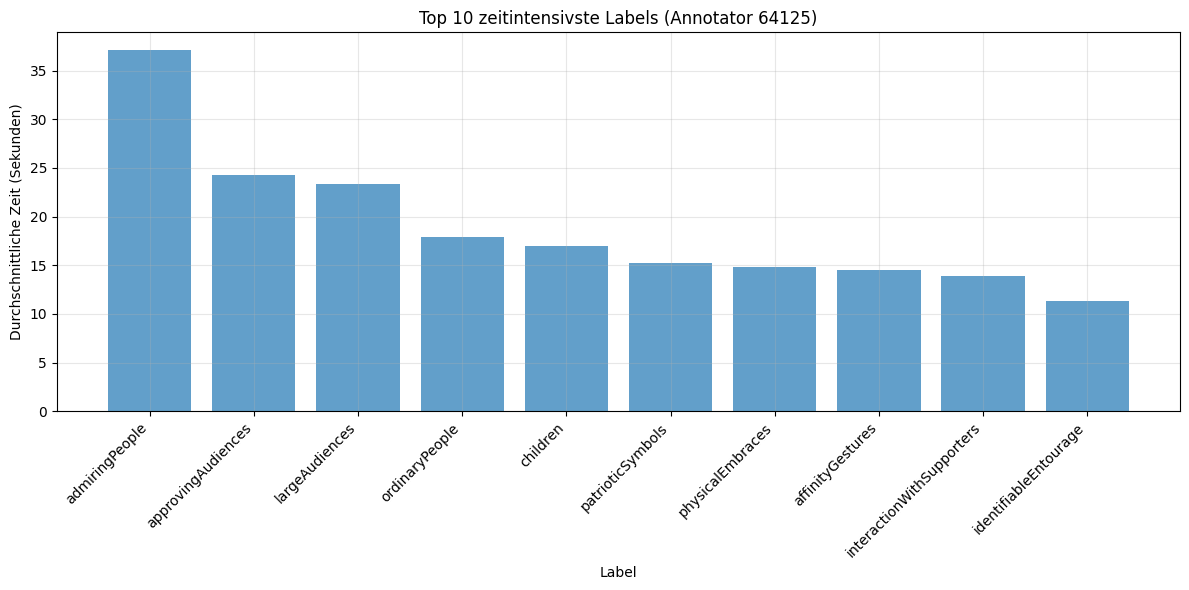

In [13]:
def calculate_annotation_efficiency(base_df):
    """Analysiert die Annotationseffizienz durch Berechnung der Zeit pro Label/Kategorie"""
    if "lead_time" not in base_df.columns:
        print("Keine Zeitinformationen in den Daten vorhanden.")
        return None

    efficiency_metrics = {}

    if "labels" in base_df.columns:
        exploded_df = base_df.explode("labels")
    else:
        if "label" in base_df.columns:
            exploded_df = base_df.copy()
            exploded_df.rename(columns={"label": "labels"}, inplace=True)
        else:
            print("Keine Label-Informationen in den Daten gefunden.")
            return None

    for annotator_id in exploded_df["annotator_id"].unique():
        annotator_df = exploded_df[exploded_df["annotator_id"] == annotator_id]

        avg_time_per_label = annotator_df.groupby("labels")["lead_time"].mean()

        total_time_per_label = annotator_df.groupby("labels")["lead_time"].sum()

        count_per_label = annotator_df["labels"].value_counts()

        total_time = base_df[base_df["annotator_id"] == annotator_id]["lead_time"].sum()
        avg_time_per_image = base_df[base_df["annotator_id"] == annotator_id][
            "lead_time"
        ].mean()

        efficiency_metrics[annotator_id] = {
            "avg_time_per_label": avg_time_per_label.to_dict(),
            "total_time_per_label": total_time_per_label.to_dict(),
            "count_per_label": count_per_label.to_dict(),
            "total_time": total_time,
            "avg_time_per_image": avg_time_per_image,
        }

    return efficiency_metrics


print("Berechne Annotationseffizienz...")
efficiency_metrics = calculate_annotation_efficiency(base_df)

if efficiency_metrics:
    for annotator_id, metrics in efficiency_metrics.items():
        print(f"\nAnnotationseffizienz für Annotator {annotator_id}:")
        print(f"Gesamtzeit: {metrics['total_time']:.2f} Sekunden")
        print(
            f"Durchschnittliche Zeit pro Bild: {metrics['avg_time_per_image']:.2f} Sekunden"
        )

        avg_time_df = pd.DataFrame(
            list(metrics["avg_time_per_label"].items()),
            columns=["Label", "Durchschnittliche Zeit (Sekunden)"],
        )
        count_df = pd.DataFrame(
            list(metrics["count_per_label"].items()), columns=["Label", "Anzahl"]
        )

        efficiency_df = avg_time_df.merge(count_df, on="Label")
        efficiency_df = efficiency_df.sort_values(
            by="Durchschnittliche Zeit (Sekunden)", ascending=False
        )

        print("\nDurchschnittliche Zeit pro Label:")
        display(efficiency_df)

        plt.figure(figsize=(12, 6))
        top_10 = efficiency_df.head(10)
        plt.bar(top_10["Label"], top_10["Durchschnittliche Zeit (Sekunden)"], alpha=0.7)
        plt.title(f"Top 10 zeitintensivste Labels (Annotator {annotator_id})")
        plt.xlabel("Label")
        plt.ylabel("Durchschnittliche Zeit (Sekunden)")
        plt.xticks(rotation=45, ha="right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"efficiency_annotator_{annotator_id}.png")
        plt.show()


Berechne Fehlerrate pro Kategorie...

Fehlerraten pro Label (absteigend sortiert):


,Label,Fehlerrate,Anzahl Uneinigkeiten
0,identifiableEntourage,0.259740,80
1,admiringPeople,0.201299,62
2,ordinaryPeople,0.188312,58
3,campaignParaphernalia,0.162338,50
4,informalAttire,0.116883,36
5,formalAttire,0.107143,33
6,interactionWithSupporters,0.103896,32
7,largeAudiences,0.097403,30
8,patrioticSymbols,0.058442,18
9,affinityGestures,0.032468,10


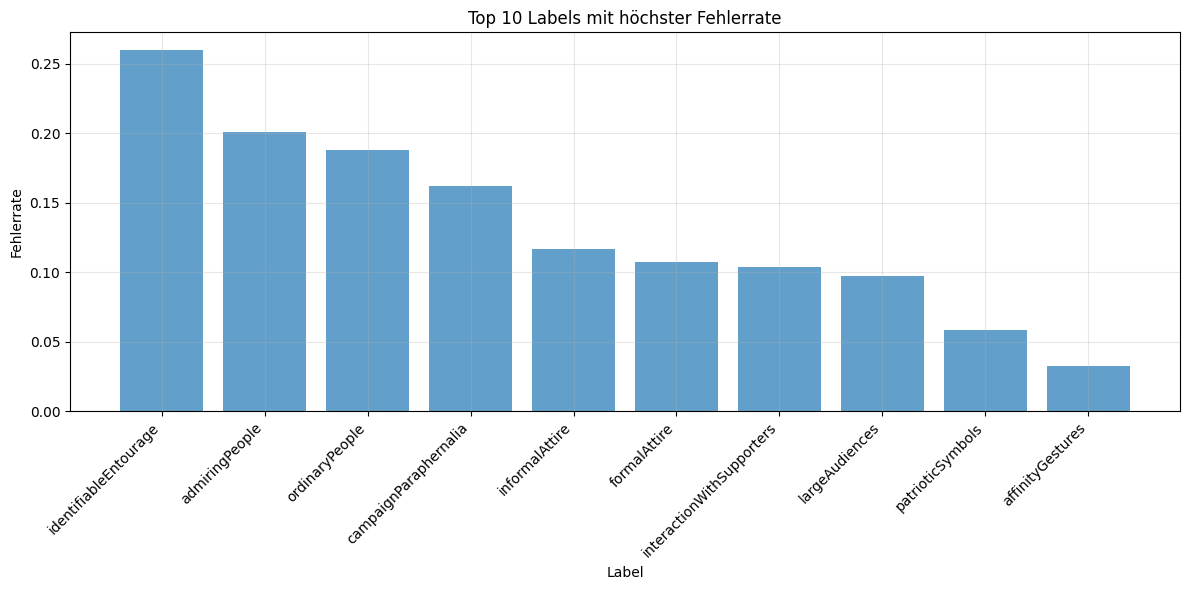

In [14]:
def calculate_error_rate_per_category(one_hot_df, unique_labels, annotator_ids):
    """
    Berechnet die Fehlerrate pro Kategorie/Label, definiert als der Anteil der Bilder,
    bei denen sich die Annotatoren uneinig sind
    """

    error_rates = {}
    disagreement_counts = {}

    for label in unique_labels:
        col1 = f"{label}_{annotator_ids[0]}"
        col2 = f"{label}_{annotator_ids[1]}"

        if col1 in one_hot_df.columns and col2 in one_hot_df.columns:
            disagreements = (one_hot_df[col1] != one_hot_df[col2]).sum()

            total_images = len(one_hot_df)

            error_rate = disagreements / total_images if total_images > 0 else 0
            error_rates[label] = error_rate
            disagreement_counts[label] = disagreements

    sorted_error_rates = {
        k: v
        for k, v in sorted(error_rates.items(), key=lambda item: item[1], reverse=True)
    }
    sorted_disagreement_counts = {
        k: disagreement_counts[k] for k in sorted_error_rates.keys()
    }

    return sorted_error_rates, sorted_disagreement_counts


print("Berechne Fehlerrate pro Kategorie...")
error_rates, disagreement_counts = calculate_error_rate_per_category(
    one_hot_df, unique_labels, annotator_ids
)

error_df = pd.DataFrame(
    {
        "Label": list(error_rates.keys()),
        "Fehlerrate": list(error_rates.values()),
        "Anzahl Uneinigkeiten": list(disagreement_counts.values()),
    }
)

print("\nFehlerraten pro Label (absteigend sortiert):")
display(error_df)

# Visualisierung der Top 10 problematischsten Labels
plt.figure(figsize=(12, 6))
top_10 = error_df.head(10)
plt.bar(top_10["Label"], top_10["Fehlerrate"], alpha=0.7)
plt.title("Top 10 Labels mit höchster Fehlerrate")
plt.xlabel("Label")
plt.ylabel("Fehlerrate")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("error_rates.png")
plt.show()


In [ ]:
def calculate_label_specific_agreement(one_hot_df, unique_labels, annotator_ids):
    """Berechnet spezifische Übereinstimmungsmetriken für jedes Label"""
    agreement_metrics = {}

    for label in unique_labels:
        col1 = f"{label}_{annotator_ids[0]}"
        col2 = f"{label}_{annotator_ids[1]}"

        if col1 in one_hot_df.columns and col2 in one_hot_df.columns:
            rater1 = one_hot_df[col1].values
            rater2 = one_hot_df[col2].values

            percent_agreement = (rater1 == rater2).mean()

            both_yes = ((rater1 == 1) & (rater2 == 1)).sum()
            both_no = ((rater1 == 0) & (rater2 == 0)).sum()
            yes_no = ((rater1 == 1) & (rater2 == 0)).sum()
            no_yes = ((rater1 == 0) & (rater2 == 1)).sum()

            agreement_metrics[label] = {
                "percent_agreement": percent_agreement,
                "both_yes": both_yes,
                "both_no": both_no,
                "yes_no": yes_no,
                "no_yes": no_yes,
            }

    return agreement_metrics


print("Berechne Label-spezifische Übereinstimmungsmetriken...")
label_agreement = calculate_label_specific_agreement(
    one_hot_df, unique_labels, annotator_ids
)


agreement_data = []
for label, metrics in label_agreement.items():
    agreement_data.append(
        {
            "Label": label,
            "Prozentuale Übereinstimmung": metrics["percent_agreement"],
            "Beide Ja": metrics["both_yes"],
            "Beide Nein": metrics["both_no"],
            "Anno1 Ja, Anno2 Nein": metrics["yes_no"],
            "Anno1 Nein, Anno2 Ja": metrics["no_yes"],
        }
    )

agreement_df = pd.DataFrame(agreement_data)
agreement_df = agreement_df.sort_values(
    by="Prozentuale Übereinstimmung", ascending=False
)

print("\nLabel-spezifische Übereinstimmungsmetriken:")
display(agreement_df)


Berechne Label-spezifische Übereinstimmungsmetriken...

Label-spezifische Übereinstimmungsmetriken:


,Label,Prozentuale Übereinstimmung,Beide Ja,Beide Nein,"Anno1 Ja, Anno2 Nein","Anno1 Nein, Anno2 Ja"
2,approvingAudiences,0.983766,0,303,0,5
4,children,0.977273,9,292,0,7
8,interactionWithCrowds,0.977273,1,300,7,0
11,noFeatures,0.977273,300,1,0,7
14,physicalEmbraces,0.970779,3,296,9,0
1,affinityGestures,0.967532,2,296,1,9
13,patrioticSymbols,0.941558,55,235,3,15
10,largeAudiences,0.902597,32,246,28,2
9,interactionWithSupporters,0.896104,28,248,12,20
5,formalAttire,0.892857,145,130,17,16


In [ ]:
def calculate_longitudinal_consistency(base_df, annotator_ids):
    """
    Misst die Stabilität der Annotationen über die Zeit
    Berechnet die Konsistenz der Labelhäufigkeiten im Zeitverlauf
    """
    consistency_metrics = {}

    for annotator_id in annotator_ids:
        annotator_df = base_df[base_df["annotator_id"] == annotator_id].copy()

        if len(annotator_df) == 0:
            continue

        if "lead_time" in annotator_df.columns:
            annotator_df = annotator_df.sort_values(by="lead_time")

        mid_point = len(annotator_df) // 2
        early_df = annotator_df.iloc[:mid_point]
        late_df = annotator_df.iloc[mid_point:]

        early_labels = []
        late_labels = []

        for _, row in early_df.iterrows():
            if "labels" in row and isinstance(row["labels"], list):
                early_labels.extend(row["labels"])
            elif "label" in row:
                early_labels.append(row["label"])

        for _, row in late_df.iterrows():
            if "labels" in row and isinstance(row["labels"], list):
                late_labels.extend(row["labels"])
            elif "label" in row:
                late_labels.append(row["label"])

        early_label_counts = pd.Series(early_labels).value_counts(normalize=True)
        late_label_counts = pd.Series(late_labels).value_counts(normalize=True)

        all_labels = set(early_label_counts.index).union(set(late_label_counts.index))

        manhattan_distance = 0
        for label in all_labels:
            early_freq = early_label_counts.get(label, 0)
            late_freq = late_label_counts.get(label, 0)
            manhattan_distance += abs(early_freq - late_freq)

        consistency = 1 - (manhattan_distance / 2)

        consistency_metrics[annotator_id] = {
            "consistency_score": consistency,
            "early_label_counts": early_label_counts.to_dict(),
            "late_label_counts": late_label_counts.to_dict(),
        }

    return consistency_metrics


print("Berechne longitudinale Konsistenz...")
consistency_metrics = calculate_longitudinal_consistency(base_df, annotator_ids)


for annotator_id, metrics in consistency_metrics.items():
    print(
        f"\nLongitudinale Konsistenz für Annotator {annotator_id}: {metrics['consistency_score']:.4f}"
    )

    early_counts = pd.Series(metrics["early_label_counts"])
    late_counts = pd.Series(metrics["late_label_counts"])

    compare_df = pd.DataFrame(
        {"Frühe Annotationen": early_counts, "Späte Annotationen": late_counts}
    )
    compare_df = compare_df.fillna(0).sort_values(
        by="Frühe Annotationen", ascending=False
    )

    compare_df["Differenz"] = abs(
        compare_df["Frühe Annotationen"] - compare_df["Späte Annotationen"]
    )
    print(
        "\nTop 10 Labels mit den größten Unterschieden zwischen frühen und späten Annotationen:"
    )
    display(compare_df.sort_values(by="Differenz", ascending=False).head(10))


Berechne longitudinale Konsistenz...

Longitudinale Konsistenz für Annotator 64824: 0.6728

Top 10 Labels mit den größten Unterschieden zwischen frühen und späten Annotationen:


,Frühe Annotationen,Späte Annotationen,Differenz
noFeatures,0.648923,0.342482,0.306441
campaignParaphernalia,0.039290,0.155131,0.115841
admiringPeople,0.010139,0.069212,0.059073
interactionWithSupporters,0.002535,0.045346,0.042811
ordinaryPeople,0.000000,0.026253,0.026253
patrioticSymbols,0.024081,0.046539,0.022458
formalAttire,0.110266,0.089499,0.020767
largeAudiences,0.027883,0.045346,0.017463
physicalEmbraces,0.000000,0.014320,0.014320
interactionWithCrowds,0.000000,0.009547,0.009547



Longitudinale Konsistenz für Annotator 64125: 0.5273

Top 10 Labels mit den größten Unterschieden zwischen frühen und späten Annotationen:


,Frühe Annotationen,Späte Annotationen,Differenz
noFeatures,0.649682,0.303241,0.346441
campaignParaphernalia,0.058599,0.170139,0.111540
identifiableEntourage,0.011465,0.122685,0.111220
formalAttire,0.138854,0.060185,0.078668
ordinaryPeople,0.002548,0.071759,0.069211
interactionWithSupporters,0.002548,0.053241,0.050693
informalAttire,0.115924,0.068287,0.047637
patrioticSymbols,0.019108,0.063657,0.044549
largeAudiences,0.001274,0.038194,0.036921
children,0.000000,0.018519,0.018519


In [ ]:
import numpy as np


def convert_to_json_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {
            convert_to_json_serializable(key): convert_to_json_serializable(value)
            for key, value in obj.items()
        }
    elif isinstance(obj, list):
        return [convert_to_json_serializable(item) for item in obj]
    else:
        return obj


In [19]:
# Sammeln aller berechneten Metriken in einem Objekt
all_advanced_metrics = {
    # Jaccard-Metriken
    "jaccard": {"avg_jaccard": avg_jaccard, "jaccard_per_label": jaccard_per_label},
    # Credibility-Metriken
    "credibility": {
        "overall_credibility": overall_credibility,
        "credibility_per_label": credibility_per_label,
    },
    # Fehlerraten
    "error_rates": error_rates,
    # Label-spezifische Übereinstimmung
    "label_agreement": {
        label: metrics["percent_agreement"]
        for label, metrics in label_agreement.items()
    },
    # Longitudinale Konsistenz
    "longitudinal_consistency": {
        annotator_id: metrics["consistency_score"]
        for annotator_id, metrics in consistency_metrics.items()
    },
    # Effizienz-Metriken
    "efficiency": efficiency_metrics if "efficiency_metrics" in locals() else {},
}

# Als JSON speichern
with open("advanced_metrics.json", "w", encoding="utf-8") as f:
    json.dump(all_advanced_metrics, f, indent=4)

print("Alle erweiterten Metriken wurden in 'advanced_metrics.json' gespeichert.")

# Tabellarische Zusammenfassung der wichtigsten Metriken
summary_metrics = {
    "Jaccard-Ähnlichkeitsindex": avg_jaccard,
    "Credibility": overall_credibility,
}

# Longitudinale Konsistenz und andere Metriken hinzufügen
for annotator_id, metrics in consistency_metrics.items():
    summary_metrics[f"Longitudinale Konsistenz (Annotator {annotator_id})"] = metrics[
        "consistency_score"
    ]

# Top 3 Labels mit höchster und niedrigster Übereinstimmung
top_agreement = agreement_df.head(3)["Label"].tolist()
bottom_agreement = agreement_df.tail(3)["Label"].tolist()
summary_metrics["Labels mit höchster Übereinstimmung"] = ", ".join(top_agreement)
summary_metrics["Labels mit niedrigster Übereinstimmung"] = ", ".join(bottom_agreement)

# DataFrame erstellen und anzeigen
summary_df = pd.DataFrame(list(summary_metrics.items()), columns=["Metrik", "Wert"])
print("\nZusammenfassung der wichtigsten Metriken:")
display(summary_df)


TypeError: keys must be str, int, float, bool or None, not int64

In [ ]:
json_serializable_metrics = convert_to_json_serializable(all_advanced_metrics)

# Als JSON speichern
with open("advanced_metrics.json", "w", encoding="utf-8") as f:
    json.dump(json_serializable_metrics, f, indent=4)

print("Alle erweiterten Metriken wurden in 'advanced_metrics.json' gespeichert.")


Analyse der JSON Dateien einzeln und auswerten pro Projekt + Metriken / Visualisierungen


In [ ]:
annotator_ids = [64824, 64125]


project_names = [
    "Graphical Representations",
    "Clothing",
    "Crowd",
    "Interaction",
    "Environment",
]


def load_project_annotations(json_folder):
    """Lädt Annotationen aus den JSON-Dateien, getrennt nach Projekten"""

    project_data = {}
    json_files = [f for f in os.listdir(json_folder) if f.endswith(".json")]

    for json_file in json_files:
        file_path = os.path.join(json_folder, json_file)
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        if not isinstance(data, list):
            data = [data]

        project_annotations = []

        for task in data:
            image_path = task.get("data", {}).get("image")
            project_id = task.get("project")

            for annotation in task.get("annotations", []):
                completed_by = annotation.get("completed_by", {})
                if isinstance(completed_by, dict):
                    annotator_id = completed_by.get("id")
                else:
                    annotator_id = completed_by

                if annotator_id in annotator_ids:
                    lead_time = annotation.get("lead_time", 0)

                    task_labels = []
                    for result in annotation.get("result", []):
                        project_name = result.get("from_name")
                        choices = result.get("value", {}).get("choices", [])

                        if not choices:
                            choices = ["no_features"]

                        for choice in choices:
                            task_labels.append(
                                {
                                    "project_name": project_name,
                                    "project_id": project_id,
                                    "image": image_path,
                                    "annotator_id": annotator_id,
                                    "label": choice,
                                    "selected": 1,
                                    "lead_time": lead_time,
                                }
                            )

                    if not task_labels:
                        task_labels.append(
                            {
                                "project_name": "keine_merkmale",
                                "project_id": project_id,
                                "image": image_path,
                                "annotator_id": annotator_id,
                                "label": "no_features",
                                "selected": 1,
                                "lead_time": lead_time,
                            }
                        )

                    project_annotations.extend(task_labels)

        project_id = data[0].get("project") if data else None
        if project_id:
            project_data[project_id] = project_annotations

    return project_data


def create_complete_label_matrix(annotations):
    """Erstellt eine vollständige Matrix mit allen Labels (auch nicht gewählte)"""

    df = pd.DataFrame(annotations)
    all_images = df["image"].unique()
    all_labels = df["label"].unique()

    complete_matrix = []

    for image in all_images:
        for annotator_id in annotator_ids:
            selected_labels = set(
                df[(df["image"] == image) & (df["annotator_id"] == annotator_id)][
                    "label"
                ].tolist()
            )

            for label in all_labels:
                complete_matrix.append(
                    {
                        "project_id": df["project_id"].iloc[0],
                        "image": image,
                        "annotator_id": annotator_id,
                        "label": label,
                        "selected": 1 if label in selected_labels else 0,
                    }
                )

    return pd.DataFrame(complete_matrix)


def calculate_metrics_for_project(project_annotations):
    """Berechnet Metriken für ein einzelnes Projekt"""

    if not project_annotations:
        return None, None

    complete_df = create_complete_label_matrix(project_annotations)

    label_metrics = {}
    for label in complete_df["label"].unique():
        label_df = complete_df[complete_df["label"] == label]

        pivot = label_df.pivot_table(
            index="image", columns="annotator_id", values="selected", fill_value=0
        )

        if len(pivot) > 0 and all(
            annotator_id in pivot.columns for annotator_id in annotator_ids
        ):
            annotator_1 = pivot[annotator_ids[0]].values
            annotator_2 = pivot[annotator_ids[1]].values

            try:
                cohen = cohen_kappa_score(annotator_1, annotator_2)

                reliability_data = np.array([annotator_1, annotator_2])
                kripp_alpha = krippendorff.alpha(
                    reliability_data, level_of_measurement="nominal"
                )

                n_items = len(annotator_1)
                fleiss_data = np.zeros((n_items, 2))
                for i in range(n_items):
                    # Anzahl der Rater mit 0 und 1
                    fleiss_data[i, 0] = 2 - (annotator_1[i] + annotator_2[i])
                    fleiss_data[i, 1] = annotator_1[i] + annotator_2[i]
                fleiss_k = fleiss_kappa(fleiss_data)

                f1 = f1_score(annotator_1, annotator_2, zero_division=0)
                precision = precision_score(annotator_1, annotator_2, zero_division=0)
                recall = recall_score(annotator_1, annotator_2, zero_division=0)

                label_metrics[label] = {
                    "cohen_kappa": cohen,
                    "krippendorff_alpha": kripp_alpha,
                    "fleiss_kappa": fleiss_k,
                    "f1_score": f1,
                    "precision": precision,
                    "recall": recall,
                }
            except Exception as e:
                print(f"Fehler bei der Berechnung für Label {label}: {e}")
                label_metrics[label] = {
                    "cohen_kappa": np.nan,
                    "krippendorff_alpha": np.nan,
                    "fleiss_kappa": np.nan,
                    "f1_score": np.nan,
                    "precision": np.nan,
                    "recall": np.nan,
                }

    combo_metrics = {}
    df = pd.DataFrame(project_annotations)
    images = df["image"].unique()

    label_combinations = []
    for image in images:
        for annotator_id in annotator_ids:
            labels = df[
                (df["image"] == image)
                & (df["annotator_id"] == annotator_id)
                & (df["selected"] == 1)
            ]["label"].tolist()

            if len(labels) > 1:
                for r in range(2, min(len(labels) + 1, 4)):
                    for combo in combinations(labels, r):
                        label_combinations.append(" + ".join(sorted(combo)))

    combo_counts = {}
    for combo in label_combinations:
        combo_counts[combo] = combo_counts.get(combo, 0) + 1

    common_combos = [combo for combo, count in combo_counts.items() if count >= 3]

    for combo_str in common_combos:
        combo_labels = combo_str.split(" + ")

        combo_selections = []

        for image in images:
            row = []

            for annotator_id in annotator_ids:
                selected_labels = set(
                    df[
                        (df["image"] == image)
                        & (df["annotator_id"] == annotator_id)
                        & (df["selected"] == 1)
                    ]["label"].tolist()
                )

                selected = (
                    1 if all(label in selected_labels for label in combo_labels) else 0
                )
                row.append(selected)

            combo_selections.append(row)

        combo_data = np.array(combo_selections)
        annotator_1 = combo_data[:, 0]
        annotator_2 = combo_data[:, 1]

        try:
            cohen = cohen_kappa_score(annotator_1, annotator_2)
            combo_metrics[combo_str] = cohen
        except:
            combo_metrics[combo_str] = np.nan

    return label_metrics, combo_metrics


def main(json_folder):
    """Hauptfunktion für die Analyse"""

    # Annotationen laden, nach Projekt getrennt
    print("Lade Annotationen...")
    project_data = load_project_annotations(json_folder)

    # Ergebnisse für alle Projekte
    all_results = {}

    for project_id, annotations in project_data.items():
        print(f"Verarbeite Projekt ID: {project_id}")

        project_name = None
        if annotations:
            project_name_set = set(
                item.get("project_name")
                for item in annotations
                if item.get("project_name") != "keine_merkmale"
            )
            if project_name_set:
                project_name = list(project_name_set)[0]

        label_metrics, combo_metrics = calculate_metrics_for_project(annotations)

        if label_metrics and project_name:
            all_results[project_name] = {
                "label_metrics": label_metrics,
                "combo_metrics": combo_metrics,
            }

    for project_name, metrics in all_results.items():
        print(f"\n## Ergebnisse für {project_name}-annotationen:\n")

        print("Einzelne Labels:")
        for label, values in metrics["label_metrics"].items():
            # Cohen's Kappa ist oft das wichtigste Maß
            print(f"{label}: {values['cohen_kappa']:.4f}")

        print("\nLabel-Kombinationen:")
        if metrics["combo_metrics"]:
            for combo, value in metrics["combo_metrics"].items():
                print(f"{combo}: {value:.4f}")
        else:
            print("Keine häufigen Label-Kombinationen gefunden.")

    with open("annotation_metrics.json", "w", encoding="utf-8") as f:
        json.dump(all_results, f, indent=2)

    print("\nAllе Ergebnisse wurden als 'annotation_metrics.json' gespeichert.")

    return all_results


json_folder = "annotations_without_review"
results = main(json_folder)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Angenommen, df enthält Ihre Label-Häufigkeiten
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Barplot für Label-Häufigkeiten pro Annotator
grouped_df = df.groupby(["label", "annotator_id"]).size().reset_index(name="count")
pivot_df = grouped_df.pivot(
    index="label", columns="annotator_id", values="count"
).fillna(0)

# Sortieren nach Häufigkeit des ersten Annotators
pivot_df = pivot_df.sort_values(by=annotator_ids[0], ascending=False)

# Erstellen des Barplots
ax = pivot_df.plot(kind="bar", width=0.8)
plt.title("Häufigkeit der Labels pro Annotator", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Anzahl", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend([f"Annotator {annotator_ids[0]}", f"Annotator {annotator_ids[1]}"])

# Werte über den Balken anzeigen
for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.tight_layout()
plt.savefig("label_frequency.png")
plt.show()


In [ ]:
# Erstellen einer Konfusionsmatrix für jedes Label
def create_agreement_heatmap(one_hot_df, unique_labels):
    agreement_matrix = np.zeros((len(unique_labels), len(unique_labels)))

    for i, label1 in enumerate(unique_labels):
        for j, label2 in enumerate(unique_labels):
            col1_anno1 = f"{label1}_{annotator_ids[0]}"
            col1_anno2 = f"{label1}_{annotator_ids[1]}"
            col2_anno1 = f"{label2}_{annotator_ids[0]}"
            col2_anno2 = f"{label2}_{annotator_ids[1]}"

            if all(
                col in one_hot_df.columns
                for col in [col1_anno1, col1_anno2, col2_anno1, col2_anno2]
            ):
                # Jaccard-Koeffizient zwischen den Labels
                intersection = (
                    (one_hot_df[col1_anno1] == 1) & (one_hot_df[col2_anno2] == 1)
                ).sum()
                union = (
                    (one_hot_df[col1_anno1] == 1) | (one_hot_df[col2_anno2] == 1)
                ).sum()

                if union > 0:
                    agreement_matrix[i, j] = intersection / union

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        agreement_matrix,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        xticklabels=unique_labels,
        yticklabels=unique_labels,
    )
    plt.title("Übereinstimmungsmatrix zwischen Labels", fontsize=16)
    plt.xlabel(f"Annotator {annotator_ids[1]} Labels", fontsize=14)
    plt.ylabel(f"Annotator {annotator_ids[0]} Labels", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("agreement_heatmap.png")
    plt.show()


heatmap = create_agreement_heatmap(one_hot_df, unique_labels)

In [ ]:
def plot_radar_chart(metrics_df, title):
    # Radar-Chart für die Übereinstimmungsmetriken
    categories = metrics_df.index
    N = len(categories)

    # Die gewünschten Metriken auswählen
    values = metrics_df["cohen_kappa"].values
    values2 = metrics_df["f1_score"].values

    # Winkel für jede Kategorie
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))  # Schließen des Polygons
    values2 = np.concatenate((values2, [values2[0]]))
    angles += angles[:1]  # Schließen der Winkel

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.plot(angles, values, "o-", linewidth=2, label="Cohen's Kappa")
    ax.plot(angles, values2, "o-", linewidth=2, label="F1 Score")
    ax.fill(angles, values, alpha=0.25)
    ax.fill(angles, values2, alpha=0.25)

    # Kategorien beschriften
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)

    # Y-Achse konfigurieren
    ax.set_ylim(-0.1, 1.0)
    ax.set_yticks(np.arange(-0.1, 1.1, 0.2))

    # Titel und Legende
    plt.title(title, size=15, pad=20)
    plt.legend(loc="upper right")

    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()


# Verwenden mit Ihren Daten
plot_radar_chart(metrics_df, "Inter-Rater-Agreement nach Label")


In [ ]:
def plot_jaccard_similarity(jaccard_per_label):
    # DataFrame erstellen
    jaccard_df = pd.DataFrame(
        list(jaccard_per_label.items()), columns=["Label", "Jaccard-Index"]
    )
    jaccard_df = jaccard_df.sort_values("Jaccard-Index", ascending=False)

    plt.figure(figsize=(12, 8))
    bars = plt.bar(jaccard_df["Label"], jaccard_df["Jaccard-Index"], color="skyblue")

    # Schwellenwerte für Übereinstimmungsqualität einzeichnen
    plt.axhline(y=0.8, color="g", linestyle="--", label="Sehr gut (0.8)")
    plt.axhline(y=0.6, color="y", linestyle="--", label="Gut (0.6)")
    plt.axhline(y=0.4, color="r", linestyle="--", label="Ausreichend (0.4)")

    # Formatierung
    plt.title("Jaccard-Ähnlichkeitsindex pro Label", fontsize=16)
    plt.xlabel("Label", fontsize=14)
    plt.ylabel("Jaccard-Index", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.05)
    plt.legend()

    # Werte über den Balken anzeigen
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            f"{bar.get_height():.2f}",
            ha="center",
            fontsize=9,
        )

    plt.tight_layout()
    plt.savefig("jaccard_similarity.png")
    plt.show()


plot_jaccard_similarity(jaccard_per_label)

In [ ]:
def plot_metrics_scatter(metrics_df):
    plt.figure(figsize=(14, 8))

    # Verschiedene Metriken als x und y verwenden
    plt.scatter(
        metrics_df["cohen_kappa"],
        metrics_df["f1_score"],
        s=100,
        c=metrics_df.index.map(lambda x: hash(x) % 256),
        alpha=0.7,
        edgecolors="k",
    )

    # Beschriftungen hinzufügen
    for i, label in enumerate(metrics_df.index):
        plt.annotate(
            label,
            (metrics_df["cohen_kappa"].iloc[i], metrics_df["f1_score"].iloc[i]),
            xytext=(5, 5),
            textcoords="offset points",
        )

    # Quadranten mit Interpretation
    plt.axhline(y=0.6, color="gray", linestyle="--")
    plt.axvline(x=0.6, color="gray", linestyle="--")

    # Beschriften der Quadranten
    plt.text(0.9, 0.9, "Hohe Übereinstimmung", ha="center", va="center", fontsize=12)
    plt.text(
        0.3,
        0.9,
        "Gute Erkennung/Schlechte Übereinstimmung",
        ha="center",
        va="center",
        fontsize=12,
    )
    plt.text(
        0.9,
        0.3,
        "Gute Übereinstimmung/Schlechte Erkennung",
        ha="center",
        va="center",
        fontsize=12,
    )
    plt.text(0.3, 0.3, "Problematische Labels", ha="center", va="center", fontsize=12)

    plt.title("Cohen's Kappa vs. F1-Score für alle Labels", fontsize=16)
    plt.xlabel("Cohen's Kappa", fontsize=14)
    plt.ylabel("F1-Score", fontsize=14)
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("metrics_scatter.png")
    plt.show()


plot_metrics_scatter(metrics_df)